# Classification algorithm evaluation

## Basic

To begin the discussion, let's look at the construction of a confusion matrix of a classification algorithm. Consider a trained classification algorithm:

In [1]:
# import a data set
# data set from https://github.com/agconti/kaggle-titanic
import pandas as pd
df_train = pd.read_csv('./train.csv',index_col='PassengerId')
print(df_train)  # print the data for display

             Survived  Pclass  \
PassengerId                     
1                   0       3   
2                   1       1   
3                   1       3   
4                   1       1   
5                   0       3   
6                   0       3   
7                   0       1   
8                   0       3   
9                   1       3   
10                  1       2   
11                  1       3   
12                  1       1   
13                  0       3   
14                  0       3   
15                  0       3   
16                  1       2   
17                  0       3   
18                  1       2   
19                  0       3   
20                  1       3   
21                  0       2   
22                  1       2   
23                  1       3   
24                  1       1   
25                  0       3   
26                  1       3   
27                  0       3   
28                  0       1   
29        

In [2]:
# let's see if we can use Sex, Age and Port of Embarkment to predict the ticket class
# use Scikit-learn for machine learning algorithms
from sklearn.neighbors import KNeighborsClassifier  # K neighbour algorithm
model = KNeighborsClassifier(n_neighbors=3)
# remove all nan data for simplicity
df_train = df_train.loc[:, ['Survived', 'Sex', 'Age', 'Embarked', 'Pclass']]
df_train = df_train.dropna(how='any')
# conduct some preprocssing to replace text data with numbers
assignments = {}
for item in ['Sex', 'Embarked']:
    assignments[item] = {}
    for ind, val in enumerate(df_train.loc[:, item].unique()):
        df_train.loc[df_train[item] == val, item] = ind
        print('Assigning', ind, 'to the value', val, 'in', item)
        # record the assignments for potential future use
        assignments[item][val] = ind
# train the model
model.fit(df_train.loc[:, ['Sex', 'Age', 'Embarked']], df_train.Pclass)

Assigning 0 to the value male in Sex
Assigning 1 to the value female in Sex
Assigning 0 to the value S in Embarked
Assigning 1 to the value C in Embarked
Assigning 2 to the value Q in Embarked


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

Now let's check the accuracy at the training data with

* Confusion matrix: a table showing the pairing of the predicted classes with the actual classes of the data points
* Accuracy scores: a ratio of the number of data points on the diagonal of the confusion matrix to the total number of data points

In [3]:
from sklearn.metrics import confusion_matrix
# let's see what the algorithm's predictions are first
pred_class = model.predict(df_train.loc[:, ['Sex', 'Age', 'Embarked']])
# now we can form the confusion matrix using the estimated classes and the actual classes of the data points
confusion_tab = confusion_matrix(df_train.Pclass, pred_class)
print(confusion_tab)

[[145  10  29]
 [ 61  58  54]
 [ 89  36 230]]


In [4]:
# let's beautify it
confusiontab_df = pd.DataFrame(confusion_tab,
                               index=[''.join(['True class ', str(ind)]) for ind in range(1, 4)],
                               columns=[''.join(['Predicted class ', str(ind)]) for ind in range(1, 4)])
print(confusiontab_df)

              Predicted class 1  Predicted class 2  Predicted class 3
True class 1                145                 10                 29
True class 2                 61                 58                 54
True class 3                 89                 36                230


So for data points with Pclass 1, 145 cases are correct predicted, but 10 of them are predicted to be class 2 and 29 of them are predicted to be class 3.

But how can we know the overall performance? We can calculate the accuracy score and see the percentage of data points on the diagonal of the confusion matrix.

In [5]:
model.score(df_train.loc[:, ['Sex', 'Age', 'Embarked']], df_train.Pclass)

0.6081460674157303

The result shows that only 60.8% of data points are classified correctly.

# Cross-validation

Using all training data to see if the model is good is inappropriate because we have no clue how good the estimation is at points not included in the training data. To avoid this issue, we can use cross-validation by dividing a dataset into small subsets, building models with the same algorithms but different training subsets separately, and calculate the accuracy scores of the model with the data not in their training subsets.

In [6]:
# split up the data into 5 subsets
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model, df_train.loc[:, ['Sex', 'Age', 'Embarked']], df_train.Pclass, cv=5)
print(scores)

[0.5034965  0.48251748 0.51748252 0.48591549 0.4893617 ]


The accuracy score of the model is actually around 50% only, which is much lower than the previous 60.8% score.

# True and false positive rate

To simplify our discussion, let's consider using the classification algorithm to predict if a person is dead in the incident. This is done by building another classification model on the data 'Survived':

In [7]:
from sklearn.svm import SVC # "Support vector classifier"
model = SVC(kernel='linear')
# train the model using half of the result, use the rest for testing
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_train.loc[:, ['Sex', 'Age', 'Embarked']],
                                                    df_train.Survived, test_size=0.5, random_state=50)
model.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

To visualize the result, let's look at the confusion table.

In [8]:
# let's use the other half of the data for the evaluation
pred_dead = model.predict(X_test)
# now we can form the confusion matrix using the estimated classes and the actual classes of the data points
confusion_tab = confusion_matrix(y_test, pred_dead)

# let's beautify it
confusiontab_df = pd.DataFrame(confusion_tab,
                               index=['Dead', 'Survived'],
                               columns=['Predicted to be dead', 'Predicted to have survived'])
print(confusiontab_df)

          Predicted to be dead  Predicted to have survived
Dead                       180                          34
Survived                    42                         100


Let's consider

* True positive rate to be the correct identification rate to predict a person to be dead
* False positive rate to be the prediction rate of falsely identify a living person to be dead

and calculate the scores

In [9]:
score = model.score(X_test, y_test)
print('Accuracy score is %.2f%%' % (score*100))
tp_rate = confusiontab_df.loc['Dead', 'Predicted to be dead']/confusiontab_df.loc['Dead', :].sum()
print('True positive rate is %.2f%%' % (tp_rate*100))
fp_rate = confusiontab_df.loc['Survived', 'Predicted to be dead']/confusiontab_df.loc['Survived', :].sum()
print('False positive rate is %.2f%%' % (fp_rate*100))

Accuracy score is 78.65%
True positive rate is 84.11%
False positive rate is 29.58%


You can see how different they are. If you are doing classification in general, __your accuracy score is ~80%__. But if you focus on not only predicting a dead person but avoid the prediction of a living person to be dead, you have to consider the __~30% false positive rate__!

# Receiver operating characteristic (ROC) curve

In some occasions, your algorithm may have tuning parameters from the user to adjust the classification (e.g. rate of alarms from the classification algorithm). But you still want to develop the algorithm so that it works at all tuning levels (i.e. not very high false alarm rate). ROC curve will help you.

Consider the previous case of the prediction if a person is dead in an incident. In the next attempt, you would like to use the regularization strength of the Logisitic Regression classifier as a tunable parameter, and you want to know the performance of the algorithm under range of C from 0.01 to 0.2. So you calculate the true and false positive rates at different C values

In [10]:
# Calculating the true and false positive rates at different cs
from sklearn.linear_model import LogisticRegression
cs = []
tp_rates = []
fp_rates = []
for c in range(1, 20):
    model = LogisticRegression(C=c*0.01)
    tab_half = int(df_train.shape[0]/2.0)
    model.fit(X_train, y_train)
    pred_dead = model.predict(X_test)
    confusion_tab = confusion_matrix(y_test, pred_dead)
    confusiontab_df = pd.DataFrame(confusion_tab,
                                   index=['Dead', 'Survived'],
                                   columns=['Predicted to be dead', 'Predicted to have survived'])
    tp_rate = confusiontab_df.loc['Dead', 'Predicted to be dead']/confusiontab_df.loc['Dead', :].sum()*100.0
    fp_rate = confusiontab_df.loc['Survived', 'Predicted to be dead']/confusiontab_df.loc['Survived', :].sum()*100.0
    cs.append(c*0.5)
    tp_rates.append(tp_rate)
    fp_rates.append(fp_rate)

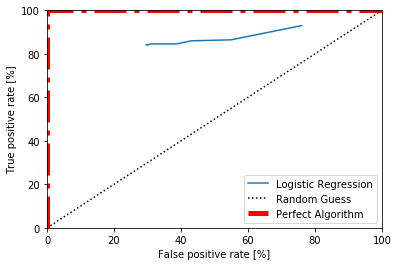

In [11]:
# Now it's time to plot the results
%matplotlib inline
import matplotlib.pylab as plt

def plot_roc(fp_rates, tp_rates):
    plt.plot(fp_rates, tp_rates, '-', label='Logistic Regression')
    plt.xlabel('False positive rate [%]')
    plt.ylabel('True positive rate [%]')
    plt.xlim([0, 100])
    plt.ylim([0, 100])
    plt.plot([0, 100], [0, 100], 'k:', label='Random Guess')  # Don't forget the curve for random guess
    plt.plot([0, 0, 100], [0, 100, 100], 'r-.', linewidth=5, label='Perfect Algorithm')
    plt.legend()

plot_roc(fp_rates, tp_rates)

Beyond C = 0.2, the true and false positive rates do not change regardless of how much you increase C. Can we continue the adjustment?

We can.

By considering probabilities from the classifier:

In [12]:
probs = model.predict_proba(X_test)
probs

array([[0.32695501, 0.67304499],
       [0.69741471, 0.30258529],
       [0.72726157, 0.27273843],
       [0.2922225 , 0.7077775 ],
       [0.70604007, 0.29395993],
       [0.77167464, 0.22832536],
       [0.39930633, 0.60069367],
       [0.71559045, 0.28440955],
       [0.77289137, 0.22710863],
       [0.32951631, 0.67048369],
       [0.73862868, 0.26137132],
       [0.65825411, 0.34174589],
       [0.73411877, 0.26588123],
       [0.71559045, 0.28440955],
       [0.6963051 , 0.3036949 ],
       [0.80016641, 0.19983359],
       [0.31681368, 0.68318632],
       [0.71665827, 0.28334173],
       [0.32440399, 0.67559601],
       [0.72262918, 0.27737082],
       [0.72830221, 0.27169779],
       [0.70119534, 0.29880466],
       [0.79263307, 0.20736693],
       [0.32186336, 0.67813664],
       [0.65538543, 0.34461457],
       [0.70460207, 0.29539793],
       [0.71901107, 0.28098893],
       [0.78489208, 0.21510792],
       [0.32186336, 0.67813664],
       [0.74419609, 0.25580391],
       [0.

So the classification algorithm can be seen as the confirmation of the first column probability to be higher than 0.5. Now if we keep increasing the probability threshold and re-plot the diagram:

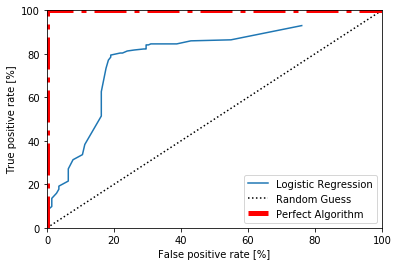

In [13]:
for prob_thres in [0.5+0.005*(ind+1) for ind in range(100)]:
    pred_dead = [int(chk) for chk in probs[:, 0] < prob_thres]
    confusion_tab = confusion_matrix(y_test, pred_dead)
    confusiontab_df = pd.DataFrame(confusion_tab,
                                   index=['Dead', 'Survived'],
                                   columns=['Predicted to be dead', 'Predicted to have survived'])
    tp_rate = confusiontab_df.loc['Dead', 'Predicted to be dead']/confusiontab_df.loc['Dead', :].sum()*100.0
    fp_rate = confusiontab_df.loc['Survived', 'Predicted to be dead']/confusiontab_df.loc['Survived', :].sum()*100.0
    cs.append(c*0.5)
    tp_rates.append(tp_rate)
    fp_rates.append(fp_rate)

plot_roc(fp_rates, tp_rates)

If you are able to connect the (0, 0) with (100, 100) for your algorithm, you can even calculate the area of the ROC as a metric of the performance of the classification algorithm.

Assume that we have a linear relationship between the rightmost point and the (100, 100) point in the ROC curve:

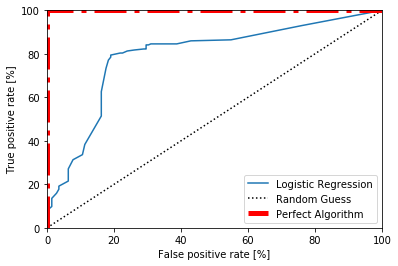

In [14]:
tp_rates = [100]+tp_rates
fp_rates = [100]+fp_rates
plot_roc(fp_rates, tp_rates)

We can compute the area of the ROC curve using numerical integration on the true and false positive rate of the data.

In [15]:
import numpy as np
aroc = -np.trapz(tp_rates, fp_rates)/10000.0  # 10000.0 to normalize the area
# negative sign for the descending order of the data
print('The area under the ROC curve is', aroc)

The area under the ROC curve is 0.7913979202316703


The area under ROC curve of a random guess algorithm is 0.5, while the one of a perfect algorithm is 1.0. This gives you a general understanding of how good the algorithm works under all thresholds.

## Additional information

This Jupyter Notebook is written by Howard Cheung for the presentation "How can we know that a machine learning algorithm classifies and detects faults well?" at PyData Hong Kong on 2018/10/25.

References for this document include:

Cheung, H., Braun, J. E., & Langner, M. R. (2016). Methodology to Assess No Touch Audit Software Using Simulated Building Utility Data (No. NREL/SR-5500-66001). Golden, CO: National Renewable Energy Laboratory. Retrieved from http://www.nrel.gov/docs/fy17osti/66001.pdf

Fawcett, T. (2006). An introduction to ROC analysis. Pattern Recognition Letters, 27(8), 861–874. https://doi.org/10.1016/j.patrec.2005.10.010

Frank, S., Heaney, M., Jin, X., Robertson, J., Cheung, H., Elmore, R., & Henze, G. (2016). Hybrid Model-Based and Data-Driven Fault Detection and Diagnostics for Commercial Buildings. In 2016 ACEEE Summer Study on Energy Efficiency in Buildings. Retrieved from http://www.nrel.gov/docs/fy16osti/65924.pdf

Kaggle. Titanic: Machine Learning from Disaster. Retrieved October 23, 2018, from https://www.kaggle.com/c/titanic

VanderPlas, J. (2016). Python Data Science Handbook: Essential Tools for Working with Data (1 edition). Sebastopol, CA: O’Reilly Media. Retrieved from https://jakevdp.github.io/PythonDataScienceHandbook/index.html